In [1]:
import sys

sys.path.append('..')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import f1_score, RocCurveDisplay, mean_squared_error

from src.data.data_transformer import DataTransformer

In [3]:
train = pd.read_parquet('../data/raw/train_dataset_hackaton2023_train.gzip')

In [4]:
train = DataTransformer(is_train=True).fit_transform(
    X=train
)

### Задача классификация

In [5]:
X_buy_post, y_buy_post = train.drop(['buy_post', 'startdatetime', 'customer_id', 'date_diff_post'], axis=1), train['buy_post']

In [6]:
X_buy_post

,MaxMinDelta,MeanOrderPrice,FavoriteDish,FavoriteHour,MostVisitedFormat,is_food_court,is_toilet
0,57,230.39,9,9,1,0,1
34,51,283.00,29,9,0,0,1
149,50,493.40,2,15,2,1,0
248,27,144.48,50,21,3,0,0
455,15,558.94,43,11,2,1,0
...,...,...,...,...,...,...,...
24261871,1,389.05,5,11,2,1,0
24261882,0,603.78,2,15,4,1,1
24261928,0,412.70,156,21,2,1,0
24261958,0,454.97,465,12,1,0,1


In [7]:
X_train_buy_post, X_test_buy_post, y_train_buy_post, y_test_buy_post = train_test_split(
    X_buy_post, y_buy_post,
    test_size=0.33,
    shuffle=True,
    random_state=55
)

In [8]:
forest_classifier = RandomForestClassifier(n_estimators=1000, max_depth=20, class_weight='balanced', random_state=21)

In [9]:
forest_classifier.fit(
    X=X_train_buy_post,
    y=y_train_buy_post
)

RandomForestClassifier(class_weight='balanced', max_depth=30, n_estimators=1000,
                       random_state=21)

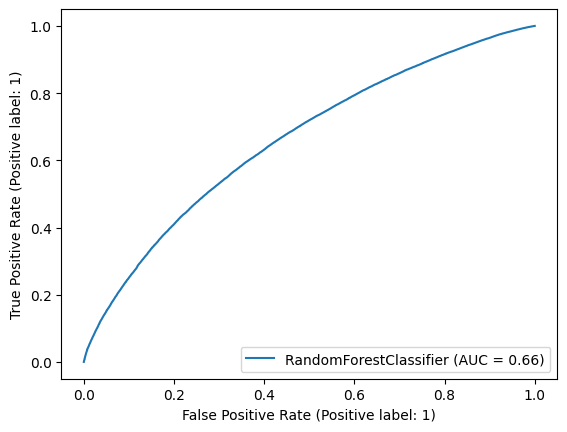

In [10]:
RocCurveDisplay.from_estimator(
    estimator=forest_classifier,
    X=X_test_buy_post,
    y=y_test_buy_post
)

In [11]:
f1_score(
    y_pred=forest_classifier.predict(X_test_buy_post),
    y_true=y_test_buy_post
)

0.8111771005744328

In [ ]:
cross_val_score(
    estimator=forest_classifier,
    X=X_train_buy_post,
    y=y_train_buy_post,
    cv=4,
    scoring='f1'
)

array([0.81214119, 0.81091791, 0.813113  , 0.81170786])

In [12]:
forest_classifier.feature_importances_

array([0.24992955, 0.40130025, 0.20094084, 0.11844802, 0.02113326,
       0.00370083, 0.00454726])

### Сохранение модели

In [13]:
import pickle

filename = "../model/third_random_forest_classifier.pickle"

pickle.dump(forest_classifier, open(filename, "wb"))

### Подберем параметры для задачи классификации

In [ ]:
param_grid = {
    'n_estimators': [100, 1000],
    'max_depth': [20, 30, 40],
    'min_samples_split': [100, 1000, 5000],
}

In [ ]:
grid_classifier = GridSearchCV(
    estimator=RandomForestClassifier(class_weight='balanced', random_state=21),
    param_grid=param_grid,
    scoring='f1',
    n_jobs=6,
    cv=3,
    verbose=10
)

In [ ]:
grid_classifier.fit(
    X=X_train_buy_post,
    y=y_train_buy_post
)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV 3/3; 1/18] START max_depth=20, min_samples_split=100, n_estimators=100......
[CV 1/3; 1/18] START max_depth=20, min_samples_split=100, n_estimators=100......
[CV 2/3; 2/18] START max_depth=20, min_samples_split=100, n_estimators=1000.....
[CV 2/3; 1/18] START max_depth=20, min_samples_split=100, n_estimators=100......
[CV 3/3; 2/18] START max_depth=20, min_samples_split=100, n_estimators=1000.....
[CV 1/3; 2/18] START max_depth=20, min_samples_split=100, n_estimators=1000.....
[CV 3/3; 1/18] END max_depth=20, min_samples_split=100, n_estimators=100;, score=0.743 total time=  28.9s
[CV 1/3; 3/18] START max_depth=20, min_samples_split=1000, n_estimators=100.....
[CV 1/3; 1/18] END max_depth=20, min_samples_split=100, n_estimators=100;, score=0.742 total time=  29.5s
[CV 2/3; 3/18] START max_depth=20, min_samples_split=1000, n_estimators=100.....
[CV 2/3; 1/18] END max_depth=20, min_samples_split=100, n_estimators=100;, scor

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=21),
             n_jobs=6,
             param_grid={'max_depth': [20, 30, 40],
                         'min_samples_split': [100, 1000, 5000],
                         'n_estimators': [100, 1000]},
             scoring='f1', verbose=10)

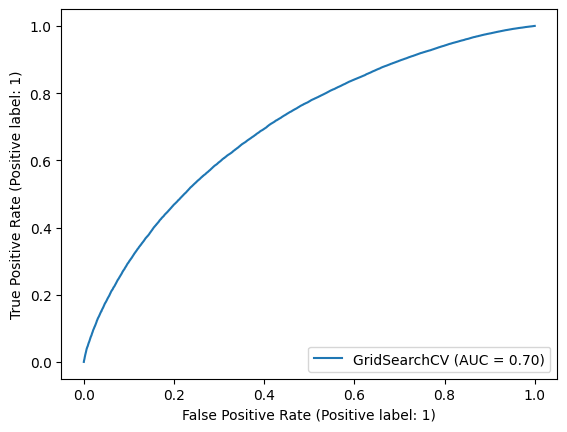

In [ ]:
RocCurveDisplay.from_estimator(
    estimator=grid_classifier,
    X=X_test_buy_post,
    y=y_test_buy_post
)

In [ ]:
f1_score(
    y_pred=grid_classifier.predict(X_test_buy_post),
    y_true=y_test_buy_post
)

0.7456681094826518

### Задача регрессии

In [62]:
X_diff_post, y_diff_post = train.drop(['buy_post', 'startdatetime', 'customer_id', 'date_diff_post'], axis=1), train['date_diff_post']

In [63]:
X_diff_post

,MaxMinDelta,MeanOrderPrice,FavoriteDish,FavoriteHour,MostVisitedFormat,is_food_court,is_toilet
0,57,230.39,9,9,1,0,1
34,51,283.00,29,9,0,0,1
149,50,493.40,2,15,2,1,0
248,27,144.48,50,21,3,0,0
455,15,558.94,43,11,2,1,0
...,...,...,...,...,...,...,...
24261871,1,389.05,5,11,2,1,0
24261882,0,603.78,2,15,4,1,1
24261928,0,412.70,156,21,2,1,0
24261958,0,454.97,465,12,1,0,1


In [64]:
X_train_diff_post, X_test_diff_post, y_train_diff_post, y_test_diff_post = train_test_split(
    X_diff_post, y_diff_post,
    test_size=0.33,
    shuffle=True,
    random_state=66
)

In [65]:
forest_regressor = RandomForestRegressor(n_estimators=1000, max_depth=20, random_state=55)

In [66]:
forest_regressor.fit(
    X=X_train_diff_post,
    y=y_train_diff_post
)

RandomForestRegressor(max_depth=20, random_state=55)

In [67]:
mse = mean_squared_error(
    y_pred=forest_regressor.predict(X_test_diff_post),
    y_true=y_test_diff_post
)

mse

289.8545492128177

In [68]:
rmse = mse ** 0.5

rmse

17.025115248150822

In [69]:
forest_regressor.feature_importances_

array([0.17514386, 0.3992222 , 0.19810945, 0.13344209, 0.06291533,
       0.01497201, 0.01619506])

In [70]:
import pickle

filename = "../model/new_random_forest_regressor.pickle"

pickle.dump(forest_regressor, open(filename, "wb"))

### Подберем параметры для задачи регрессии